Every year the UFC needs to choose who has been the best fighter in that year per each weight category. But how should UFC select the best fighter?

We are going to define some evaluation criterions representing them as **boolean variables**:
The fighters are evaluated on:
    - *More_wons*: more wons than loses (Yes/No)
    - *Diff_category*: fought on different category (Yes/No)
    - *Number_KOs*: number of KOs > 5 (Yes/No)
    - *Grappling_quality*: grappling quality (Good/Bad)
    - *Injuries*: injuries during the season (Yes/No)

Now we are going to define the structure of the model which means to define the relationships that exist between the previously defined variables.

In [69]:
from pgmpy.models import BayesianModel

## Model definition

In [70]:
model = BayesianModel([('More_wons', 'Best_fighter'),
                       ('Diff_category', 'Best_fighter'),
                       ('Number_KOs', 'Best_fighter'),
                       ('Injuries', 'Grappling_quality'),
                       ('Grappling_quality', 'More_wons'),
                       ('Grappling_quality', 'Number_KOs'),
                       ('Diff_category', 'Injuries')
                       ]) 

In [71]:
#Network nodes and out-edges
nodes = list(model.nodes())
edges = list(model.edges())

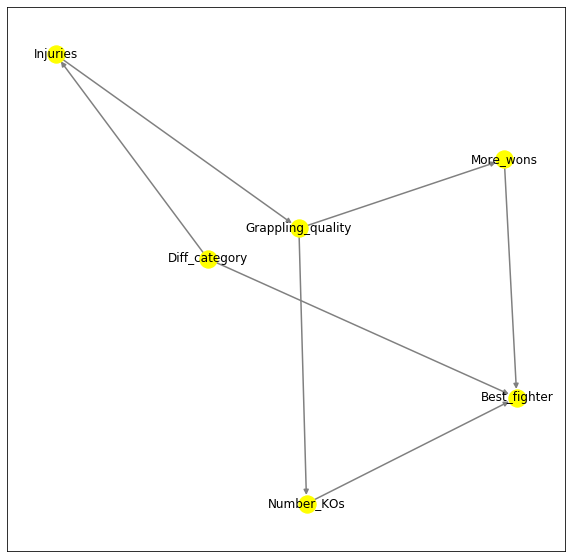

In [72]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
np.random.seed(8)

DAG = nx.DiGraph()
DAG.add_edges_from(edges)

fig = plt.figure(figsize = (10,10))
pos = nx.spring_layout(DAG) #Position nodes computed by using Fruchterman-Reingold force-directed algorithm.
nx.draw_networkx_nodes(DAG, pos=pos, node_color='yellow')
nx.draw_networkx_labels(DAG, pos=pos)
nx.draw_networkx_edges(DAG, pos=pos, edge_color='gray', width = 1.5, arrows=True)
plt.show()

## Conditional Probability Distribution

In order to make predictions with our model, we need to define the conditional probability distribution (CPD) of each variable.

By looking at the network shown above, we can easily conclude that:
    - *Diff_category* has only a **prior probability**, thus we will have just 1 entry in the corresponding CPD tables;
    - *Injuries*, *Grappling_quality*, *More_wons*, *Number_KOs* have **conditional probabilities** which means that there are 4 entries in the corresponding CPD table and for the *Best_fighter* there are 16.

In [73]:
from pgmpy.factors.discrete import TabularCPD
import numpy as np
# fought on different category
diff_category_cdp = TabularCPD('Diff_category', 2, np.array([[.7,.3]]).T)

In [74]:
# Had injureies
injuries_cpd=TabularCPD('Injuries', 2, [[.70,.3],[.3,.7]],
                       evidence=['Diff_category'],
                       evidence_card=[2])

In [75]:
# Grappling quality
grappling_quality_cpd=TabularCPD('Grappling_quality', 2, [[.7,.4],[.3,.6]],
                       evidence=['Injuries'],
                       evidence_card=[2])

In [76]:
# Has more wons than loses
more_wons_cpd=TabularCPD('More_wons', 2, [[.85,.4],[.15,.6]],
                       evidence=['Grappling_quality'],
                       evidence_card=[2])

In [77]:
# Number of KOs > 5
number_KOs_cpd=TabularCPD('Number_KOs', 2, [[.6,.2],[.4,.8]],
                       evidence=['Grappling_quality'],
                       evidence_card=[2])

In [78]:
#Not chosen/chosen to be the best fighter given Number_KOs, Diff_Category and More_wons
best_fighter_cpd=TabularCPD('Best_fighter',2,[[.95,.73,.7,.23,.35,.20,.28,.1],[.05,.27,.3,.77,.65,.8,.72,.9]],
                       evidence=['Number_KOs','Diff_category','More_wons'],
                       evidence_card=[2,2,2]) 

In [79]:
model.add_cpds(diff_category_cdp,
               injuries_cpd,
               grappling_quality_cpd,
               more_wons_cpd,
               number_KOs_cpd,
               best_fighter_cpd)

#Verify the model correctness by:
#  -checking if the sum of the probabilities for each state is equal to 1;
#  -checking if the CPDs associated with nodes are consistent with their parents.
if model.check_model():
    print("No errors in the defined model.")

No errors in the defined model.


## Inferece

#### Exact Inference

In [21]:
from pgmpy.inference import VariableElimination

exact_inference = VariableElimination(model)

query1 = exact_inference.query(['Commission'])
query2 = exact_inference.query(['Commission'],{'Writing':0})
query3 = exact_inference.query(['Writing', 'Bilingual'], {'Commission':0}) 
query4 = exact_inference.map_query(['Commission', 'Writing', 'Grad_with_honors'], {'Reading':1}) 

print('\nP(Commission)\n\n',query1)
print('\n\nP(Commission|Writing=poor)\n\n',query2)
print('\n\nP(Reading, Bilingual|Commission=no)\n\n',query3)
print('\n\nMAP of Reading = > 3\n\n',query4)

Eliminating: Bilingual: 100%|██████████| 1/1 [00:00<00:00, 398.85it/s]


P(Commission)

 +---------------+-------------------+
| Commission    |   phi(Commission) |
+===============+===================+
| Commission(0) |            0.5901 |
+---------------+-------------------+
| Commission(1) |            0.4099 |
+---------------+-------------------+


P(Commission|Writing=poor)

 +---------------+-------------------+
| Commission    |   phi(Commission) |
+===============+===================+
| Commission(0) |            0.6720 |
+---------------+-------------------+
| Commission(1) |            0.3280 |
+---------------+-------------------+


P(Reading, Bilingual|Commission=no)

 +--------------+------------+--------------------------+
| Bilingual    | Writing    |   phi(Bilingual,Writing) |
+==============+============+==========================+
| Bilingual(0) | Writing(0) |                   0.7258 |
+--------------+------------+--------------------------+
| Bilingual(0) | Writing(1) |                   0.1754 |
+--------------+------------+---------

#### Approximate inference

In [22]:
query = exact_inference.query(['Reading'], {'Bilingual' : 1,'Commission' : 0})
print("\nP(Reading | Bilingual = yes, Commission = no)\n\n",query)

reference_prob = query.values[1]

Eliminating: Writing: 100%|██████████| 2/2 [00:00<00:00, 317.39it/s]


P(Reading | Bilingual = yes, Commission = no)

 +------------+----------------+
| Reading    |   phi(Reading) |
+============+================+
| Reading(0) |         0.8292 |
+------------+----------------+
| Reading(1) |         0.1708 |
+------------+----------------+


In [23]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from pgmpy.sampling import GibbsSampling

BMS_inference = BayesianModelSampling(model)
gibbs = GibbsSampling(model)

def prob_WL(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def prob_Gibbs(samples):
    return (samples.query('Reading == 1 & Bilingual == 1 & Commission == 0').shape[0]
                /
            samples.query('Bilingual == 1 & Commission == 0').shape[0])
    
def run_experiment(sample_size):
    # Sample
    samples_WL = BMS_inference.likelihood_weighted_sample(
                      evidence = evidence, 
                      size=sample_size, 
                      return_type='recarray')
    samples_RS = BMS_inference.rejection_sample(
                      evidence = evidence, 
                      size=sample_size, 
                      return_type='recarray')
    samples_GS= gibbs.sample(size = size)
    
    # Probability
    results_WL = prob_WL(samples_WL,'Reading')
    results_RS = np.recarray.mean(samples_RS['Reading'], axis=0)
    results_GS = prob_Gibbs(samples_GS)
    
    # Return results
    return np.array([(sample_size, 
                      results_WL,
                      results_RS,
                      results_GS)], 
                    dtype=[('sample_size', '<i8'), 
                           ('results_WL', '<f8'),
                           ('results_RS', '<f8'),
                           ('results_GS', '<f8')])

In [24]:
approximate_results = np.array([], dtype=[('sample_size', '<i8'), 
                           ('results_WL', '<f8'),
                           ('results_RS', '<f8'),
                           ('results_GS', '<f8')])
initial_size = 2
final_size = 5
num = 10 
evidence = [State('Bilingual',1), State('Commission',0)]

In [25]:
for size in np.logspace(initial_size, final_size, num=num, dtype='<i8'):
    approximate_results=np.append(approximate_results,run_experiment(size))

Generating for node: Commission: 100%|██████████| 5/5 [00:00<00:00, 360.93it/s]

Generating for node: Commission: 100%|██████████| 5/5 [00:00<00:00, 130.17it/s]
150it [00:00, 2507.44it/s]             
Generating for node: Commission: 100%|██████████| 5/5 [00:00<00:00, 327.09it/s]

Generating for node: Commission: 100%|██████████| 5/5 [00:00<00:00, 73.70it/s]A
332it [00:00, 3698.12it/s]             
Generating for node: Commission: 100%|██████████| 5/5 [00:00<00:00, 146.44it/s]

Generating for node: Commission: 100%|██████████| 5/5 [00:00<00:00, 41.34it/s]
717it [00:00, 4299.61it/s]             
Generating for node: Commission: 100%|██████████| 5/5 [00:00<00:00, 173.92it/s]

Generating for node: Commission: 100%|██████████| 5/5 [00:00<00:00, 20.37it/s]      
1527it [00:00, 5407.09it/s]             
Generating for node: Commission: 100%|██████████| 5/5 [00:00<00:00, 110.32it/s]

Generating for node: Commission: 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]
3116it [00:00, 5861.14it/s]    

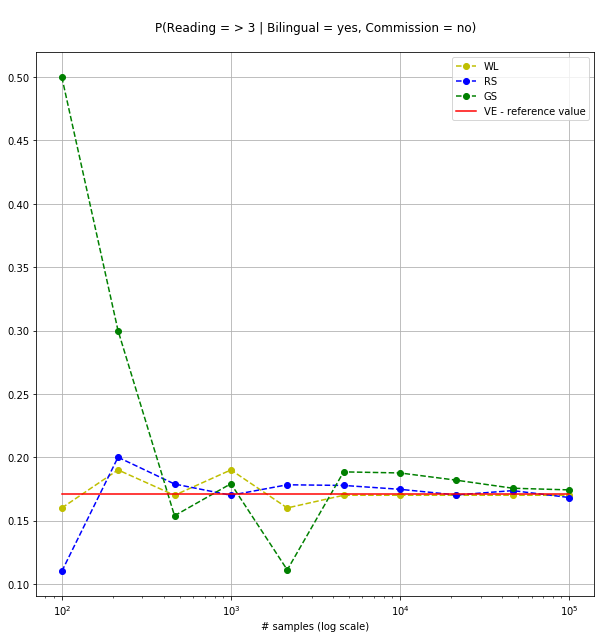

In [26]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.title('\nP(Reading = > 3 | Bilingual = yes, Commission = no)\n')
plt.xlabel("# samples (log scale)")

sizes = approximate_results['sample_size']
results_WL = approximate_results['results_WL']
results_RS = approximate_results['results_RS']
results_GS = approximate_results['results_GS']

plot_WL, = plt.semilogx(sizes, results_WL, 'yo--', label="WL")
plot_RS, = plt.semilogx(sizes, results_RS, 'bo--', label="RS")
plot_GS,= plt.semilogx(sizes, results_GS, 'go--', label="GS")
plot_VE,= plt.semilogx(sizes, reference_prob*np.ones(len(sizes)),'r', label="VE - reference value")

plt.legend(handles=[plot_WL, plot_RS, plot_GS, plot_VE])
plt.show()